### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

### Переходим к практике

In [4]:
import pandas as pd

Наши новости

In [5]:
news = pd.read_csv("./Data/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [6]:
users = pd.read_csv("./Data/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [7]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [16]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [19]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [24]:
with open('./Data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [25]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [26]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_17997/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 2min 29s, sys: 5.43 s, total: 2min 34s
Wall time: 2min 34s


In [27]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 23min 57s, sys: 2.49 s, total: 23min 59s
Wall time: 24min 2s


А теперь в 3 строчки обучим нашу модель

In [28]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [2]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [3]:
common_dictionary[10]

'ватутин'

In [4]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [5]:
from gensim.models import LdaModel

In [6]:
LdaModel?

In [7]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 6min 59s, sys: 48.6 s, total: 7min 48s
Wall time: 3min 36s


In [13]:
from gensim.test.utils import datapath
import os
# Save model to disk.
temp_file = datapath(os.path.abspath("./Data/model.lda"))
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [14]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.4946867),
 (4, 0.05361079),
 (8, 0.12759273),
 (14, 0.045258243),
 (16, 0.03920022),
 (22, 0.09642734),
 (24, 0.12412238)]

In [15]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: журнал мозг поверхность проверка nn организм свет
topic_1: наиболее энергия минимальный связанный дефицит след производитель
topic_2: военный станция риск территория космонавт база боевой
topic_3: россия nn российский новый газета глава развитие
topic_4: доллар млн доход тыс составить сближение население
topic_5: смерть жизнь болезнь умереть выдать возраст скончаться
topic_6: гражданин исследование nn территория участок торговый рейс
topic_7: млрд рост цена рубль экономика экономический исследование
topic_8: ракета восток рак земля берег турецкий океан
topic_9: китайский китай лекарство компьютерный таиланд ученик снежный
topic_10: исследование агентство помощь пациент врач nn обнаружить
topic_11: министерство космос объект содержать распоряжение освобождение атмосферный
topic_12: вода экипаж остров км земля маршрут авария
topic_13: бизнесмен девочка высота юрист приземлиться девушка законодательство
topic_14: российский путин россия владимир вопрос государство глава
topic_15:

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [16]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [17]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.491693,0.000000,0.0,0.0,0.0,0.00000,...,0.383302,0.000000,0.038532,0.000000,0.0,0.00000,0.078598,0.000000,0.000000,0.000000
1,4896,0.000000,0.0,0.0,0.639311,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.264742,0.000000,0.0,0.07276,0.000000,0.000000,0.000000,0.000000
2,4897,0.494642,0.0,0.0,0.000000,0.053606,0.0,0.0,0.0,0.12757,...,0.000000,0.039203,0.000000,0.000000,0.0,0.00000,0.000000,0.096408,0.000000,0.124225
3,4898,0.158385,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.031958,0.027594,0.0,0.00000,0.000000,0.234732,0.401508,0.091151
4,4899,0.141772,0.0,0.0,0.758860,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.073422,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [18]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [19]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [20]:
doc_dict[293622]

array([0.15065773, 0.        , 0.        , 0.06436632, 0.02099612,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21090551,
       0.        , 0.        , 0.06738868, 0.        , 0.09421036,
       0.10267907, 0.        , 0.        , 0.27725282, 0.        ])

In [147]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [148]:
get_user_embedding(user_articles_list)

array([0.00989628, 0.        , 0.04426411, 0.13952308, 0.00595471,
       0.01881846, 0.02503294, 0.0526277 , 0.        , 0.        ,
       0.03254592, 0.        , 0.00312089, 0.00294126, 0.17609678,
       0.00282174, 0.09629194, 0.        , 0.01680529, 0.        ,
       0.1220404 , 0.00279327, 0.12718512, 0.10524966, 0.00304047])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [149]:
#users['articles'].iloc[33]

In [150]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [151]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.025110,0.001687,0.020818,0.286258,0.003499,0.025053,0.045121,0.072174,0.009766,...,0.006514,0.064901,0.044978,0.000000,0.015702,0.120789,0.000000,0.027242,0.068500,0.024835
1,u108690,0.020679,0.000000,0.013896,0.195751,0.002263,0.013763,0.025569,0.096184,0.000000,...,0.046224,0.086681,0.000000,0.010490,0.001755,0.152885,0.002576,0.090959,0.038644,0.058408
2,u108339,0.026090,0.000000,0.013552,0.181917,0.001948,0.027824,0.027929,0.057084,0.000000,...,0.093851,0.101873,0.000000,0.007003,0.022928,0.104008,0.000000,0.102432,0.047407,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [152]:
target = pd.read_csv("./Data/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [153]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.025110,0.001687,0.020818,0.286258,0.003499,0.025053,0.045121,0.072174,0.009766,...,0.064901,0.044978,0.000000,0.015702,0.120789,0.000000,0.027242,0.068500,0.024835,0
1,u108690,0.020679,0.000000,0.013896,0.195751,0.002263,0.013763,0.025569,0.096184,0.000000,...,0.086681,0.000000,0.010490,0.001755,0.152885,0.002576,0.090959,0.038644,0.058408,1
2,u108339,0.026090,0.000000,0.013552,0.181917,0.001948,0.027824,0.027929,0.057084,0.000000,...,0.101873,0.000000,0.007003,0.022928,0.104008,0.000000,0.102432,0.047407,0.000000,1


In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [155]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [156]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [157]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16139812, 0.04965644, 0.47058264, 0.14562684, 0.07606703,
       0.04404562, 0.06186951, 0.02880661, 0.08581439, 0.19589877])

In [158]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [159]:
import itertools

In [160]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
precision_mean = precision[ix]
recall_mean = recall[ix]
thresholds_mean = thresholds[ix]
fscore_mean = fscore[ix]

Best Threshold=0.267958, F-Score=0.607, Precision=0.591, Recall=0.624


In [108]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1649  106]
 [  93  152]]


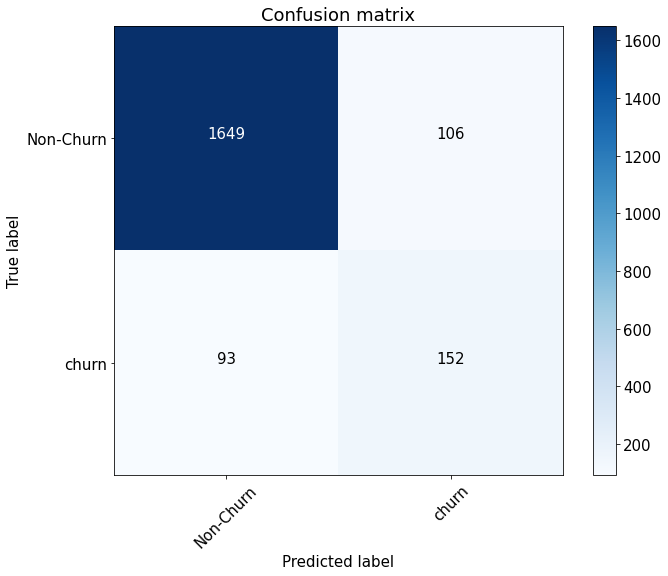

In [109]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [145]:
ras_mean = roc_auc_score(y_test, preds)

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [114]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [115]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.16296414, 0.        ,
       0.        , 0.01935665, 0.01589349, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21550022,
       0.        , 0.09824361, 0.        , 0.00866216, 0.        ,
       0.        , 0.        , 0.09782524, 0.05282467, 0.        ])

In [116]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.254602,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.034753,0.021377,0.0,0.000000,0.118858,0.0,0.000000,0.000000,0.000000
1,u108690,0.017973,0.0,0.005202,0.179372,0.0,0.006568,0.007758,0.084045,0.0,...,0.005909,0.065118,0.000000,0.0,0.000000,0.128138,0.0,0.064205,0.011828,0.006189
2,u108339,0.005362,0.0,0.010797,0.172547,0.0,0.010829,0.026749,0.035944,0.0,...,0.100621,0.110946,0.000000,0.0,0.009815,0.112032,0.0,0.099247,0.038071,0.000000


In [117]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.254602,0.0,0.000000,0.000000,0.000000,0.0,...,0.034753,0.021377,0.0,0.000000,0.118858,0.0,0.000000,0.000000,0.000000,0
1,u108690,0.017973,0.0,0.005202,0.179372,0.0,0.006568,0.007758,0.084045,0.0,...,0.065118,0.000000,0.0,0.000000,0.128138,0.0,0.064205,0.011828,0.006189,1
2,u108339,0.005362,0.0,0.010797,0.172547,0.0,0.010829,0.026749,0.035944,0.0,...,0.110946,0.000000,0.0,0.009815,0.112032,0.0,0.099247,0.038071,0.000000,1


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [119]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [120]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.13452618, 0.02853144, 0.54162057, 0.28171351, 0.04062096,
       0.020089  , 0.05511137, 0.0168986 , 0.03089251, 0.22841242])

In [121]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
def return_metrics(precision, recall, thresholds):
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore) 
    return precision[ix], recall[ix], thresholds[ix], fscore[ix]

precision_median, recall_median, thresholds_median, fscore_median = return_metrics(precision, recall, thresholds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median, 
                                                                        fscore_median,
                                                                        precision_median,
                                                                        recall_median))

Best Threshold=0.347310, F-Score=0.731, Precision=0.788, Recall=0.682


Confusion matrix, without normalization
[[1538  217]
 [  18  227]]


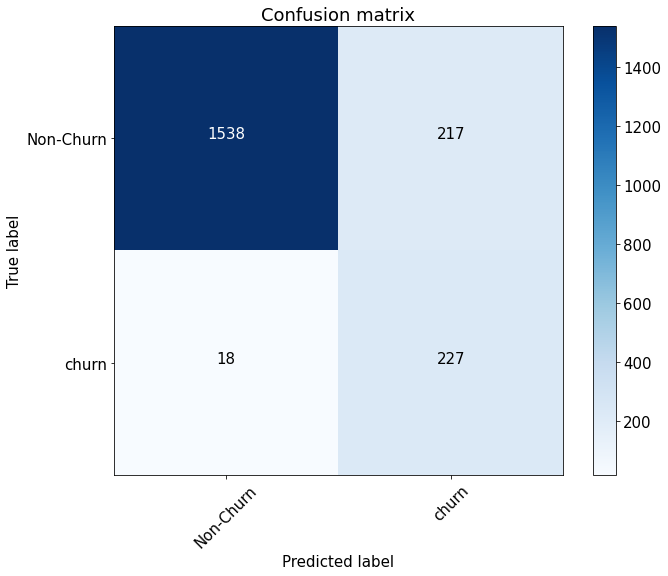

In [92]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [93]:
ras_median = roc_auc_score(y_test, preds)

3. Повторить п.2, но используя уже не медиану, а max

In [122]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [123]:
get_user_embedding(user_articles_list)

array([0.05937765, 0.        , 0.18096597, 0.24198739, 0.03572828,
       0.11291074, 0.08424378, 0.17868529, 0.        , 0.        ,
       0.16935252, 0.        , 0.01872536, 0.01764758, 0.33093172,
       0.01693046, 0.18077847, 0.        , 0.05705511, 0.        ,
       0.37174946, 0.01675962, 0.2944532 , 0.36350065, 0.0182428 ])

In [124]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.150658,0.010123,0.124908,0.494815,0.020996,0.150316,0.215611,0.433042,0.058594,...,0.039083,0.161527,0.159725,0.000000,0.094210,0.314471,0.000000,0.130605,0.277253,0.149009
1,u108690,0.054077,0.000000,0.062161,0.319501,0.013577,0.040911,0.095293,0.245999,0.000000,...,0.169868,0.243951,0.000000,0.041228,0.010530,0.335539,0.015458,0.214087,0.127999,0.281675
2,u108339,0.129951,0.000000,0.030656,0.272067,0.011689,0.132442,0.063284,0.168204,0.000000,...,0.158369,0.190178,0.000000,0.031844,0.080269,0.225793,0.000000,0.264006,0.106226,0.000000


In [125]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.150658,0.010123,0.124908,0.494815,0.020996,0.150316,0.215611,0.433042,0.058594,...,0.161527,0.159725,0.000000,0.094210,0.314471,0.000000,0.130605,0.277253,0.149009,0
1,u108690,0.054077,0.000000,0.062161,0.319501,0.013577,0.040911,0.095293,0.245999,0.000000,...,0.243951,0.000000,0.041228,0.010530,0.335539,0.015458,0.214087,0.127999,0.281675,1
2,u108339,0.129951,0.000000,0.030656,0.272067,0.011689,0.132442,0.063284,0.168204,0.000000,...,0.190178,0.000000,0.031844,0.080269,0.225793,0.000000,0.264006,0.106226,0.000000,1


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [127]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [128]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([2.05916841e-01, 6.97379706e-04, 7.60524923e-01, 3.13665322e-01,
       1.15066104e-02, 3.64716996e-02, 3.37058085e-02, 2.35216648e-02,
       2.80688110e-03, 8.15250746e-02])

In [130]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
precision_max, recall_max, thresholds_max, fscore_max = return_metrics(precision, recall, thresholds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max, 
                                                                        fscore_max,
                                                                        precision_max,
                                                                        recall_max))

Best Threshold=0.356872, F-Score=0.782, Precision=0.788, Recall=0.776


Confusion matrix, without normalization
[[1704   51]
 [  56  189]]


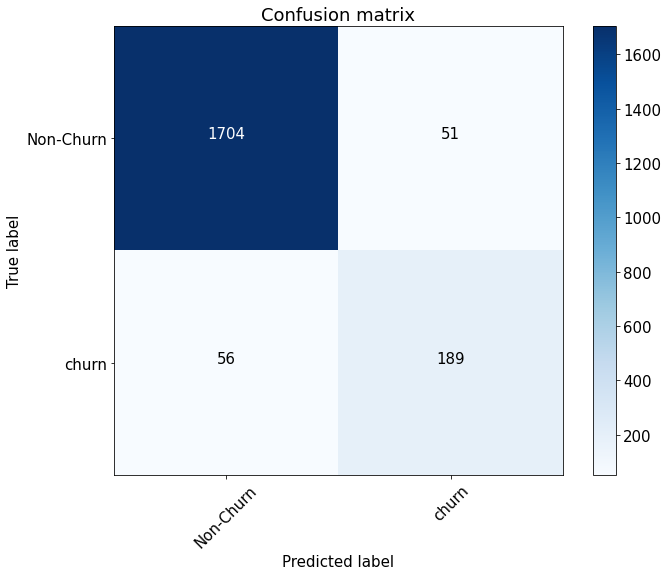

In [82]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [83]:
ras_max = roc_auc_score(y_test, preds)

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [161]:
table_data = [['mean', ras_mean, precision_mean, recall_mean, fscore_mean], 
              ['median', ras_median, precision_median, recall_median, fscore_median],
              ['max', ras_max, precision_max, recall_max, fscore_max]]
table_df = pd.DataFrame(table_data, columns=['model', 'roc_auc', 'precision', 'recall', 'f_score'])
table_df

,model,roc_auc,precision,recall,f_score
0,mean,0.918619,0.590734,0.624490,0.607143
1,median,0.965419,0.787736,0.681633,0.730853
2,max,0.969442,0.788382,0.775510,0.781893


In [162]:
dill.dump_session('./Data/lesson_2_inprocess_dump.db')

6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Предположительно наиболее качественно себя зарекомендовала модель с использованием функции max, при embedding, так как максимальные предпочтения наиболее ярко характеризуют пользователя.
Статистически median более качественный показатель,чем среднестатистический mean, поэтому модель с применением median оказалось более точная.